In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import sklearn
from sklearn.preprocessing import *
from sklearn.preprocessing import QuantileTransformer


def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

def temp_sensible(df):
    #체감온도 공식은 체감온도(℃)=13.12+0.6215×T-11.37V0.16+0.3965V0.16×T
    temp_df_t=df['temp_mean'].tolist()
    temp_df_w=df['wind_mean'].tolist()
    temp_df_t
    temp_df_w
    result_=[]
    for i in range(len(temp_df_t)):
        result=13.12+0.6215*temp_df_t[i]-11.37*math.pow(temp_df_w[i],0.16)+0.3965*math.pow(temp_df_w[i],0.16)*temp_df_t[i]
        result_.append(round(result,1))
    df.insert(4,'temp_sensible',result_)

def discomfort_index(df):
    #0.81 * temp_df_t[i] +0.01 * temp_df_t[i]*((0.99*temp_df_t[i]) - 14.3)+ 46.3
    #불쾌지수 공식(80이상 : 매우 불쾌, 80~75: 50%불쾌 , 68~75 :불쾌감 시작, 68미만: 쾌적함)
    #discomfort_index(불쾌지수)
    temp_df_t=df['temp_mean'].tolist()
    temp_df_h=df['humidity'].tolist()
    temp_df_t
    temp_df_h
    result_=[]
    for i in range(len(temp_df_t)):
        result=(9/5*temp_df_t[i])-0.55*(1-temp_df_h[i]/100)*(9/5*temp_df_t[i]-26)+32
        result_.append(round(result,1))
    result_
    df['discomfort_index']=result_


def pm_trafficlight(df):
    #미세먼지 신호등 
    pm10=df['PM10'].tolist()
    pm2=df['PM2.5'].tolist()
    pm_=[]
    for i in range(len(pm10)):
        if(pm10[i]<=30 or pm2[i]<=15):
            pm_.append(1)
        elif((pm10[i]<=80 and pm10[i]>30) or (pm2[i] >=16 and pm2[i]<=50)):
            pm_.append(2)
        elif((pm10[i]<=150 and pm10[i]>80)or (pm2[i]>50 and pm2[i]<=100)):
            pm_.append(3)
        elif(pm10[i]>=150 or (pm2[i]>100)):
            pm_.append(4)
    df['pm']=pm_

def rental_rate(df):
    #연도별 증가하는 비율을 조사하고 전체적인 비율을 맞춰주기 위해서 값들을 변환해주었다.--> 추가 설명 필요
    y1 = df[df['year'] == 2018]['rental'] * 2.3
    y2 = df[df['year'] == 2019]['rental'] * 1.2
    y3 = df[df['year'] == 2020]['rental']
    new = pd.concat([y1, y2, y3], axis=0).to_frame()
    df['rental'] = new['rental']
    return True

def seperate_date(df):
    date=df['date'].tolist()
    year=[]
    month=[]
    day=[]
    year_=''
    month_=''
    day_=''
    for j in date:
        list_=j.split("-")
        for i in range(3):
            if(i==0):
                year_+=list_[i]
            elif(i==1):
                month_+=list_[i]
            elif(i==2):
                day_+=list_[i]
        year.append(int(year_))
        month.append(int(month_))
        day.append(int(day_))
        year_=''
        month_=''
        day_=''
    df=df.drop(columns='date')
    df['year']=year
    df['month']=month
    df['day']=day
    return df

def train_day_of_the_week(df):
    day = []
    for i in range(0,614):
        if df.index[i] % 7 == 0:
            day.append("Monday")
        elif df.index[i] % 7 == 1:
            day.append("Tuesday")
        elif df.index[i] % 7 ==2:
            day.append("Wednesday")
        elif df.index[i] % 7 == 3:
            day.append("Thursday")
        elif df.index[i] % 7 == 4:
            day.append("Friday")
        elif df.index[i] % 7 == 5:
            day.append("Saturday")
        elif df.index[i] % 7 == 6:
            day.append("Sunday")
    for i in range(0,len(df.day)-614):
        if df.index[i] % 7 == 0:
            day.append("Sunday")
        elif df.index[i] % 7 == 1:
            day.append("Monday")
        elif df.index[i] % 7 == 2:
            day.append("Tuesday")
        elif df.index[i] % 7 == 3:
            day.append("Wednesday")
        elif df.index[i] % 7 == 4:
            day.append("Thursday")
        elif df.index[i] % 7 == 5:
            day.append("Friday")
        elif df.index[i] % 7 == 6:
            day.append("Saturday")
    df["day_name"] = day
    return df

def test_day_of_the_week(df):
    day2= []
    for i in range(0,365):
        if df.index[i] % 7 == 0:
            day2.append("Friday")
        elif df.index[i] % 7 == 1:
            day2.append("Saturday")
        elif df.index[i] % 7 ==2:
            day2.append("Sunday")
        elif df.index[i] % 7 == 3:
            day2.append("Monday")
        elif df.index[i] % 7 == 4:
            day2.append("Tuesday")
        elif df.index[i] % 7 == 5:
            day2.append("Wednesday")
        elif df.index[i] % 7 == 6:
            day2.append("Thursday")
    df["day_name"] = day2  
    return df



def enter_week(df):
    #요일별로 대여량에 미치는 영향이 다르다고 판단-> corr 을 통해 영향을 미치는 비율만큼 조정을 해주었다.
    d_list = [1.02,1.02, 0.97, 0.95, 1.02, 1.01, 1.02]
    #corr 해서 상관관계에 따라 비율 설정 
    for i in range(0, 7):
        df[df['day'] == i] *= d_list[i]

In [2]:
#데이터 불러오기
sample = pd.read_csv('sample_submission.csv')
sample
test_df = pd.read_csv('test.csv')
test_df
train = pd.read_csv('train.csv')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
    
train['holiday']=0
train.loc[train['date']=='2018-01-01', 'holiday'] =1
train.loc[train['date']=='2018-02-15', 'holiday'] =1
train.loc[train['date']=='2018-02-16', 'holiday'] =1
train.loc[train['date']=='2018-02-17', 'holiday'] =1
train.loc[train['date']=='2018-03-01', 'holiday'] =1
train.loc[train['date']=='2018-05-05', 'holiday'] =1
train.loc[train['date']=='2018-05-07', 'holiday'] =1
train.loc[train['date']=='2018-05-22', 'holiday'] =1
train.loc[train['date']=='2018-06-06', 'holiday'] =1
train.loc[train['date']=='2018-06-13', 'holiday'] =1
train.loc[train['date']=='2018-08-15', 'holiday'] =1
train.loc[train['date']=='2018-09-23', 'holiday'] =1
train.loc[train['date']=='2018-09-24', 'holiday'] =1
train.loc[train['date']=='2018-09-25', 'holiday'] =1
train.loc[train['date']=='2018-09-26', 'holiday'] =1
train.loc[train['date']=='2018-10-03', 'holiday'] =1
train.loc[train['date']=='2018-10-09', 'holiday'] =1
train.loc[train['date']=='2018-12-25', 'holiday'] =1

train.loc[train['date']=='2019-01-01', 'holiday'] =1
train.loc[train['date']=='2019-02-04', 'holiday'] =1
train.loc[train['date']=='2019-02-05', 'holiday'] =1
train.loc[train['date']=='2019-02-06', 'holiday'] =1
train.loc[train['date']=='2019-03-01', 'holiday'] =1
train.loc[train['date']=='2019-05-12', 'holiday'] =1
train.loc[train['date']=='2019-06-06', 'holiday'] =1
train.loc[train['date']=='2019-08-15', 'holiday'] =1
train.loc[train['date']=='2019-09-12', 'holiday'] =1
train.loc[train['date']=='2019-09-13', 'holiday'] =1
train.loc[train['date']=='2019-09-14', 'holiday'] =1
train.loc[train['date']=='2019-10-03', 'holiday'] =1
train.loc[train['date']=='2019-10-09', 'holiday'] =1
train.loc[train['date']=='2019-12-25', 'holiday'] =1

train.loc[train['date']=='2020-01-01', 'holiday'] =1
train.loc[train['date']=='2020-01-24', 'holiday'] =1
train.loc[train['date']=='2020-01-25', 'holiday'] =1
train.loc[train['date']=='2020-01-26', 'holiday'] =1
train.loc[train['date']=='2020-01-27', 'holiday'] =1
train.loc[train['date']=='2020-03-01', 'holiday'] =1
train.loc[train['date']=='2020-04-15', 'holiday'] =1
train.loc[train['date']=='2020-04-30', 'holiday'] =1
train.loc[train['date']=='2020-05-05', 'holiday'] =1
train.loc[train['date']=='2020-06-06', 'holiday'] =1
train.loc[train['date']=='2020-08-15', 'holiday'] =1
train.loc[train['date']=='2020-08-17', 'holiday'] =1
train.loc[train['date']=='2020-09-30', 'holiday'] =1
train.loc[train['date']=='2020-10-01', 'holiday'] =1
train.loc[train['date']=='2020-10-02', 'holiday'] =1
train.loc[train['date']=='2020-10-03', 'holiday'] =1
train.loc[train['date']=='2020-10-09', 'holiday'] =1
train.loc[train['date']=='2020-12-25', 'holiday'] =1


test_df.loc[train['date']=='2021-01-01', 'holiday'] =1
test_df.loc[train['date']=='2021-02-11', 'holiday'] =1
test_df.loc[train['date']=='2021-02-12', 'holiday'] =1
test_df.loc[train['date']=='2021-02-13', 'holiday'] =1
test_df.loc[train['date']=='2021-03-01', 'holiday'] =1
test_df.loc[train['date']=='2021-05-05', 'holiday'] =1
test_df.loc[train['date']=='2021-05-19', 'holiday'] =1
test_df.loc[train['date']=='2021-06-06', 'holiday'] =1
test_df.loc[train['date']=='2021-08-15', 'holiday'] =1
test_df.loc[train['date']=='2021-08-16', 'holiday'] =1
test_df.loc[train['date']=='2021-09-20', 'holiday'] =1
test_df.loc[train['date']=='2021-09-21', 'holiday'] =1
test_df.loc[train['date']=='2021-09-22', 'holiday'] =1
test_df.loc[train['date']=='2021-10-03', 'holiday'] =1
test_df.loc[train['date']=='2021-10-04', 'holiday'] =1
test_df.loc[train['date']=='2021-10-09', 'holiday'] =1
test_df.loc[train['date']=='2021-10-11', 'holiday'] =1
test_df.loc[train['date']=='2021-12-25', 'holiday'] =1
test_df.loc[train['date']=='2021-12-27', 'holiday'] =1



In [4]:

# train['holiday']=0
# t_holiday_list=['2018-01-01','2018-02-15','2018-02-16','2018-02-17', '2018-03-01','2018-05-05','2018-05-07', '2018-05-22', '2018-06-06','2018-06-13', '2018-08-15', '2018-09-23','2018-09-24', '2018-09-25', 
# '2018-09-26', '2018-10-03','2018-10-09', '2018-12-25','2019-01-01','2019-02-04', '2019-02-05','2019-02-06','2019-03-01','2019-05-12','2019-06-06','2019-08-15', '2019-09-12', '2019-09-13','2019-09-14', '2019-10-03','2019-10-09', 
# '2019-12-25', '2020-01-01','2020-01-24','2020-01-25','2020-01-26', '2020-01-27', '2020-03-01','2020-04-15','2020-04-30','2020-05-05','2020-06-06',
# '2020-08-15','2020-08-17','2020-09-30','2020-10-01','2020-10-02','2020-10-03','2020-10-09','2020-12-25']
                
# for i in t_holiday_list:
#     train.loc[train['date']==i, 'holiday'] =1


# test_df['holiday']=0
# test_holiday_list=['2021-01-01','2021-02-11', '2021-02-12', '2021-02-13','2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06','2021-08-15',
# '2021-08-16', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03','2021-10-04','2021-10-09', '2021-10-11', '2021-12-25', '2021-12-27']
# for i in test_holiday_list:
#     test_df.loc[test_df['date']==i, 'holiday'] =1


In [5]:

train_=seperate_date(train)
train_['precipitation']=train_['precipitation'].fillna(0)
train_['PM10'] = train_['PM10'].fillna(train_['PM10'].mean())
train_['PM2.5'] = train_['PM2.5'].fillna(train_['PM2.5'].mean())
train_ = train_.fillna(train_.mean())
rental_rate(train_)
train_=train_day_of_the_week(train_)
train_= pd.get_dummies(data = train_,columns = ['day_name'])
train_["rental"] = np.log1p(train_["rental"])
discomfort_index(train_)
temp_sensible(train_)
train_.insert(5,'temp_diff',train_['temp_highest'] - train_['temp_lowest'])
pm_trafficlight(train_)



# test 전처리

In [6]:
test_date=test_df['date']
test_df=seperate_date(test_df)
test_df['precipitation']=test_df['precipitation'].fillna(0)
test_df['PM10'] = test_df['PM10'].fillna(test_df['PM10'].mean())
test_df['PM2.5'] = test_df['PM2.5'].fillna(test_df['PM2.5'].mean())
test_df=test_df.fillna(test_df.mean())
test_df=test_day_of_the_week(test_df)
test_df = pd.get_dummies(data = test_df,columns = ["day_name"])
discomfort_index(test_df)
temp_sensible(test_df)
#일교차
test_df.insert(5,'temp_diff',train_['temp_highest'] - train_['temp_lowest'])
#미세먼지 신호등
pm_trafficlight(test_df)


In [7]:
scaler1 = QuantileTransformer()
scaler2 = QuantileTransformer()
col___list = ['PM10','PM2.5','sunshine_rate','sunshine_sum', 'precipitation']
scaler1.fit(train_[col___list])
X_train_scaled = scaler1.transform(train_[col___list])
train_[col___list] =X_train_scaled
scaler2.fit(test_df[col___list])
X_train_scaled = scaler2.transform(test_df[col___list])
test_df[col___list] =X_train_scaled


/Users/haseung-won/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (365). n_quantiles is set to n_samples.
  warnings.warn("n_quantiles (%s) is greater than the total number "


In [8]:
# scaler1 = QuantileTransformer()
# scaler2 = QuantileTransformer()
# col___list = ['PM10','PM2.5','sunshine_rate','sunshine_sum', 'precipitation','wind_max']
# scaler1.fit(train_[col___list])
# X_train_scaled = scaler1.transform(train_[col___list])
# train_[col___list] =X_train_scaled
# scaler2.fit(test_df[col___list])
# X_train_scaled = scaler2.transform(test_df[col___list])
# test_df[col___list] =X_train_scaled


In [9]:

train_ = pd.get_dummies(data = train_,columns = ['pm'])
train_['dust'] = train_['PM10'] * train_['PM2.5']
train_['abs_diff'] = abs(train_['temp_highest'] - train_['temp_lowest'])
train_['rate'] = train_['sunshine_rate'] / train_['sunshine_sum']
train_['daytime'] = train_['daytime'].fillna(method='bfill')


test_df = pd.get_dummies(data = test_df,columns = ['pm'])
test_df['pm_4']=0.0
test_df['pm_4']=test_df['pm_4'].astype('uint8')
test_df['dust'] = test_df['PM10'] * test_df['PM2.5']
test_df['abs_diff'] = abs(test_df['temp_highest'] - test_df['temp_lowest'])
test_df['daytime'] = test_df['sunshine_rate'] / test_df['sunshine_sum']
test_df['daytime'] = test_df['daytime'].fillna(method='bfill')


In [10]:
# scaler1 = QuantileTransformer()
# scaler2 = QuantileTransformer()
# col___list = ['daytime']
# scaler1.fit(train_[col___list])
# X_train_scaled = scaler1.transform(train_[col___list])
# train_[col___list] =X_train_scaled
# scaler2.fit(test_df[col___list])
# X_train_scaled = scaler2.transform(test_df[col___list])
# test_df[col___list] =X_train_scaled

In [11]:
train_=train_.drop(columns='sunshine_sum')
test_df=test_df.drop(columns='sunshine_sum')

In [12]:
train_.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   precipitation       1095 non-null   float64
 1   temp_mean           1095 non-null   float64
 2   temp_highest        1095 non-null   float64
 3   temp_lowest         1095 non-null   float64
 4   temp_sensible       1095 non-null   float64
 5   temp_diff           1095 non-null   float64
 6   PM10                1095 non-null   float64
 7   PM2.5               1095 non-null   float64
 8   humidity            1095 non-null   float64
 9   sunshine_rate       1095 non-null   float64
 10  wind_mean           1095 non-null   float64
 11  wind_max            1095 non-null   float64
 12  rental              1095 non-null   float64
 13  holiday             1095 non-null   int64  
 14  year                1095 non-null   int64  
 15  month               1095 non-null   int64  
 16  day   

In [13]:
train = train.drop(index=788, axis = 0)#윤달 제거 아니디어 별로 안좋았음

In [14]:
import xgboost
from xgboost import XGBRegressor
from xgboost import XGBRegressor as model

y = train_['rental']
x= train_.drop('rental',axis =1)
model = XGBRegressor(objective='reg:squarederror',learning_rate=0.1,max_depth = 4, n_estimators = 1000)
model.fit(x, y)
pred = model.predict(test_df)      
pred = pd.DataFrame(pred, columns=['rental'])
pred = np.expm1(pred)*1.35


In [15]:
result = pd.concat([test_date, pred],axis=1)
result = seperate_date(result)
enter_week(result)
result = pd.concat([test_df, result['rental']],axis=1)
real_data = pd.read_csv('real_data.csv')
NMAE(real_data['rental'],pred['rental'])
#0.20994305332561805
#0.1759140807412157
#0.17160655151714022 result_2
#0.169358561366779
#0.16833088271950228 #1.03 예측값에 곱하면 더 오른다.
#0.1636956776772946 예측할때 곱하는거
#0.16183995947493923
# 0.16131674637594595
#0.15704841089546054 최종
#0.15661981889132384 최최종
#0.15656089596607772 자꾸 줄어드냨ㅋㅋㅋ
#0.1564804266463955 오호 해보자 이거냐?

0.15971368643401082

In [16]:
sample['rental'] = pred
sample

,date,rental
0,2021-01-01,27550.500000
1,2021-01-02,26879.683594
2,2021-01-03,17775.929688
3,2021-01-04,33266.390625
4,2021-01-05,26452.082031
...,...,...
360,2021-12-27,34484.773438
361,2021-12-28,37353.417969
362,2021-12-29,46339.921875
363,2021-12-30,35921.660156


In [17]:
sample.to_csv('7.02result2.csv',index=False, encoding = 'UTF-8')
real_data

,date,rental
0,2021-01-01,22274
1,2021-01-02,23631
2,2021-01-03,21809
3,2021-01-04,32957
4,2021-01-05,29033
...,...,...
360,2021-12-27,42521
361,2021-12-28,51268
362,2021-12-29,52017
363,2021-12-30,48993


In [18]:
sum(pred['rental'])

31474208.169921875

In [19]:
sum(real_data['rental'])

32054693

<AxesSubplot:>

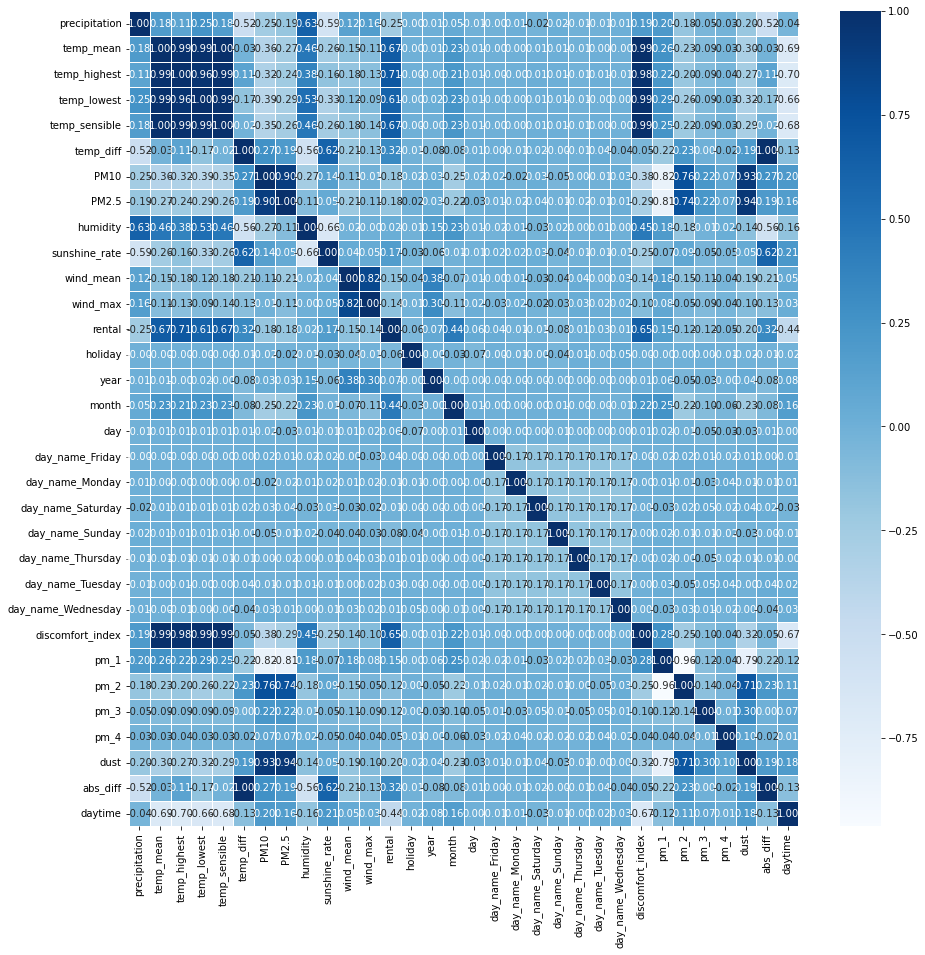

In [20]:
plt.figure(figsize=(15,15))
sns.heatmap(data = train_.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')